---
## **Title: "Predicting the Severity of Heart Disease Using Cleveland Heart Disease Dataset"**
- Author: Eric Wang
- Date: 2024-06-19
---
## Introduction
Heart disease is a major health concern worldwide, accounting for millions of deaths each year. Early detection and prevention are crucial in managing and reducing the risk of heart disease. Machine learning models play a crucial role in predicting the likelihood of heart disease in individuals[1]. These models assist doctors in diagnosing heart disease more quickly and accurately, enabling timely medical interventions.

In this project, I aim to develop a predictive model using the Cleveland Heart Disease dataset to determine the likelihood of an individual having heart disease based on various medical attributes and lifestyle factors. The primary question this project seeks to answer is: **"Is it possible to predict the severity of heart disease based on chest pain type, resting blood pressure, and thalassemia across all age groups and sexes"**

---
## Variables Used In Prediction
- **age_group**: the age of the patient categorized into different groups
    - Children: Age ≤ 17 years
    - Young Adults: Age 18 to 34 years
    - Adults: Age 35 to 49 years
    - Middle-aged Adults: Age 50 to 64 years
    - Seniors: Age ≥ 65 years
- **sex**: the biological sex of the patient
    - Male
    - Female
- **cp**: types of chest pain
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- **trestbps**: resting blood pressure (in mm Hg on admission to the hospital)
- **thal**: thalassemia status
    - 3: Normal
    - 6: Fixed defect
    - 7: Reversible defect
- **num**: diagnosis of heart disease (angiographic disease status)
    - 0: No significant heart disease, with < 50% diameter narrowing.
    - 1: Significant heart disease, with > 50% diameter narrowing in 1 major vessel.
    - 2: Significant heart disease, with > 50% diameter narrowing in 2 major vessels.
    - 3: Significant heart disease, with > 50% diameter narrowing in 3 major vessels.
    - 4: Significant heart disease, with > 50% diameter narrowing in 4 major vessels.
---
## Method
    - My goal is to use k-nearest neighbors(KNN) classification to predict the severity of heart disease based on chest pain type, resting blood pressure, and thalassemia status across all age groups and sexes. The following columns will be seleceted for analysis: cp(chest pain type), trestbps(resting blood pressure), thal(thalassemia status), age_group(age group), sex(sex), and num(serverity of heart disease). Sex will be convert into numerical values before the classification and the dataset will be divided in to subgroups by age_group. The number of neighbors(k) will be optimized using cross-validation to determine the best value for accurate predictions. The model's performance will be evaluated on the testing dataset using metrics.
---
## Results

In [1]:
#load necessary libraries
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(dplyr)
library(forcats)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#read the data and assign column names
cleveland<-read_csv("data/heart_disease/processed.cleveland.data",
                    col_names=c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"))

cleve<-cleveland|>
#Define age groups
mutate(age_group = case_when(
    age <= 17 ~ "Children",
    age >= 18 & age <= 34 ~ "Young Adults",
    age >= 35 & age <= 49 ~ "Adults",
    age >= 50 & age <= 64 ~ "Middle-aged Adults",
    age >= 65 ~ "Seniors"))|>
mutate(age_group=as.factor(age_group))|>

#Convert thal to a factor and rename values
mutate(sex=as.factor(sex))|>
mutate(sex=fct_recode(sex,"Male"="1","Female"="0"))|>

mutate(num=as.factor(num))|> #Convert num to a factor

#select specific columns for further analysis
select(age_group,sex,cp,trestbps,thal,num)

#Print the first few rows to view the data
head(cleve)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age_group,sex,cp,trestbps,thal,num
<fct>,<fct>,<dbl>,<dbl>,<chr>,<fct>
Middle-aged Adults,Male,1,145,6.0,0
Seniors,Male,4,160,3.0,2
Seniors,Male,4,120,7.0,1
Adults,Male,3,130,3.0,0
Adults,Female,2,130,3.0,0
Middle-aged Adults,Male,2,120,3.0,0


In [3]:
#Split the data into training and testing sets with stratification
set.seed(88888)
cleveland_split<-initial_split(cleve,prop=0.75,strata=num)
#Training Set
train<-training(cleveland_split)
#Testing Set
test<-testing(cleveland_split)

**Data Summarization**

In [4]:
#Summarize data for patients with insignificant heart disease
insignificant_heart_disease<-train|>

#Filter patients with insignificant heart disease
filter(num=="0")|> 

# Group data by age group and sex
group_by(age_group,sex)|>  
summarize(count=n(), # Count the number of observations in each group
          avg_trestbps=round(mean(trestbps),2), #Calculate the average resting blood pressure, rounded to 2 decimal places
          max_trestbps=max(trestbps), #Find the maximum resting blood pressure
          min_trestbps=min(trestbps)) #Find the minimum resting blood pressure

#Summarize data for patients with significant heart disease
significant_heart_disease<-train|>

#Filter patients with insignificant heart disease
filter(num!="0")|> 

# Group data by age group and sex
group_by(age_group,sex)|>  
summarize(count=n(), # Count the number of observations in each group
          avg_trestbps=round(mean(trestbps),2), #Calculate the average resting blood pressure, rounded to 2 decimal places
          max_trestbps=max(trestbps), #Find the maximum resting blood pressure
          min_trestbps=min(trestbps)) #Find the minimum resting blood pressure

#Print the summarized data with titles
print("Table 1 Insignificant Heart Disease Summary")
insignificant_heart_disease
print("Table 2 Significant Heart Disease Summary")
significant_heart_disease

`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


[1] "Table 1 Insignificant Heart Disease Summary"


age_group,sex,count,avg_trestbps,max_trestbps,min_trestbps
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
Adults,Female,16,121.81,142,94
Adults,Male,28,125.46,140,104
Middle-aged Adults,Female,24,129.42,180,102
Middle-aged Adults,Male,37,130.27,178,94
Seniors,Female,10,138.10,160,106
Seniors,Male,4,138.50,160,118
Young Adults,Female,1,118.00,118,118
Young Adults,Male,2,124.00,130,118


[1] "Table 2 Significant Heart Disease Summary"


age_group,sex,count,avg_trestbps,max_trestbps,min_trestbps
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
Adults,Female,1,132.00,132,132
Adults,Male,19,123.16,150,110
Middle-aged Adults,Female,17,142.76,180,108
Middle-aged Adults,Male,50,134.50,192,110
Seniors,Female,2,164.00,178,150
Seniors,Male,15,136.40,180,100


In [5]:
#Count the missing data in each column of the training data
Missing<-train|>

#Summarize all columns, counting the number of ? in each column
    map_df(~ sum(. == "?"))

#Print the summarized missing data with titles
print("Table 3 Missing Data")
Missing

[1] "Table 3 Missing Data"


age_group,sex,cp,trestbps,thal,num
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,1,0


**Data Visualization**

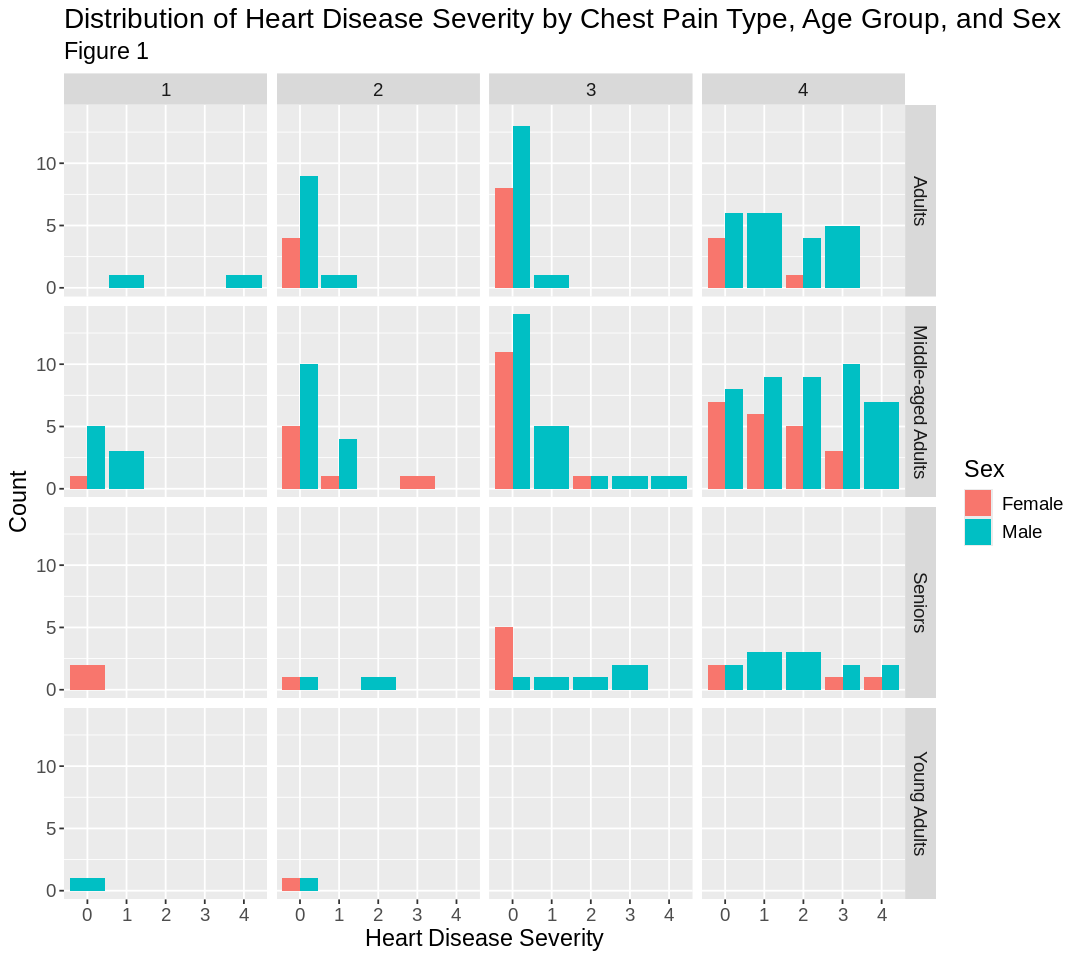

In [6]:
#Adjust the plot dimensions
options(repr.plot.height=8,repr.plot.width=9)

#Create the plot based on training data
train_plot<-train|>
#Set the x-axis to heart disease severity and fill the color by sex
ggplot(aes(x=num,fill=sex))+
#Create a bar plot with counts, dodging bars side by side for different sexes
geom_bar(stat="count",position="dodge")+
#Create facets by age group(rows) and chest pain type(columns)
facet_grid(rows=vars(age_group),cols=vars(cp))+
#Add labels and title
labs(title = "Distribution of Heart Disease Severity by Chest Pain Type, Age Group, and Sex",
     subtitle="Figure 1",
    x = "Heart Disease Severity",y = "Count",fill = "Sex")+
#Set the text size for the plot
theme(text=element_text(size=14))

#Display the plot
train_plot

---
## Data Analysis

In [7]:
#Filter NA data
cl<-filter(cleveland,thal!="?")|>

#Define age groups
mutate(age_group = case_when(
    age <= 17 ~ "Children",
    age >= 18 & age <= 34 ~ "Young Adults",
    age >= 35 & age <= 49 ~ "Adults",
    age >= 50 & age <= 64 ~ "Middle-aged Adults",
    age >= 65 ~ "Seniors"))|>
mutate(age_group=as.factor(age_group))|>
mutate(num=as.factor(num))|> #Convert num to a factor
mutate(thal=as.numeric(thal))|> #Convert thal to a double

#select specific columns for further analysis
select(age_group,sex,cp,trestbps,thal,num)

In [8]:
#Split the data into training and testing sets with stratification
set.seed(666)
cl_split<-initial_split(cl,prop=0.75,strata=num)
#Training Set
cl_train<-training(cl_split)
#Testing Set
cl_test<-testing(cl_split)

In [9]:
#Define a recipe for preprocessing the data
cl_recipe<-recipe(num~sex+cp+trestbps+thal,data=cl_train)|>
step_center(all_predictors())|> #Center all predictors
step_scale(all_predictors()) #Scale all predictors

#Define a KNN model specification
knn_spec<-nearest_neighbor(weight_func="rectangular",neighbors=tune())|>
set_engine("kknn")|>
set_mode("classification")

#Perform 5-fold cross-validation
cl_vfold<-vfold_cv(cl_train,v=5,strata=num)

#Define a range of neighbor values to be tuned
kgrid<-tibble(neighbors=c(3:15))

#Build the workflow
cl_fit<-workflow()|>
add_recipe(cl_recipe)|>
add_model(knn_spec)|>
tune_grid(resamples = cl_vfold, grid = kgrid)|>
collect_metrics()|>
filter(.metric=="accuracy")

→ A | warning: No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





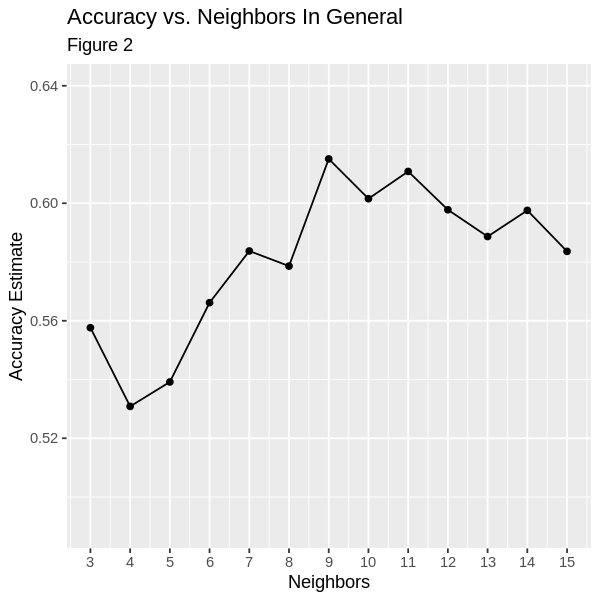

In [10]:
options(repr.plot.width=5,repr.plot.height=5)

#Create a plot of accuracy versus the number of neighbors
accuracy_versus_k <- ggplot(cl_fit, aes(x = neighbors, y = mean))+
geom_point() + #Add points to plot
geom_line() + #Connect points with a line
labs(x = "Neighbors", y = "Accuracy Estimate",
    title="Accuracy vs. Neighbors In General",
    subtitle="Figure 2") + #Label axis
scale_x_continuous(breaks = seq(3, 15, by = 1)) +  # adjusting the x-axis
scale_y_continuous(limits = c(0.49, 0.64)) # adjusting the y-axis
accuracy_versus_k

In [11]:
#Filter Young Adults from the dataset
cl_train_1<-cl_train|>
filter(age_group=="Young Adults")
#Too few data, cannot predict k

In [12]:
#Filter Adults from the dataset
cl_train_2<-cl_train|>
filter(age_group=="Adults")

#Define a recipe for preprocessing the data
cl_recipe_2<-recipe(num~sex+cp+trestbps+thal,data=cl_train_2)|>
step_center(all_predictors())|> #Center all predictors
step_scale(all_predictors()) #Scale all predictors

#perform 5-fold cross-validation
cl_vfold_2<-vfold_cv(cl_train_2,v=5,strata=num)

#Build the workflow
cl_fit_2<-workflow()|>
add_recipe(cl_recipe_2)|>
add_model(knn_spec)|>
tune_grid(resamples = cl_vfold_2, grid = kgrid)|>
collect_metrics()|>
filter(.metric=="accuracy")

→ A | warning: No observations were detected in `truth` for level(s): '2', '4'
               Computation will proceed by ignoring those levels.

→ B | warning: No observations were detected in `truth` for level(s): '3', '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x2   B: x1

→ C | warning: No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x2   B: x1
There were issues with some computations   A: x2   B: x1   C: x2





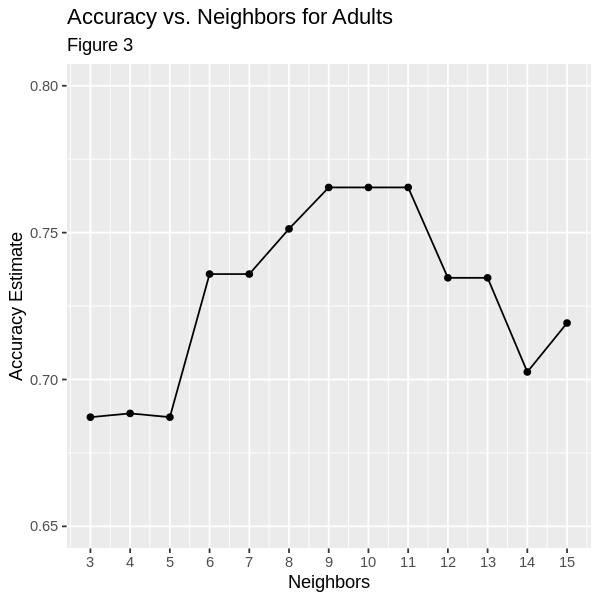

In [13]:
options(repr.plot.width=5,repr.plot.height=5)

#Create a plot of accuracy versus the number of neighbors
accuracy_versus_k_2 <- ggplot(cl_fit_2, aes(x = neighbors, y = mean))+
geom_point() + #Add points to plot
geom_line() + #Connect points with a line
labs(x = "Neighbors", y = "Accuracy Estimate",
    title="Accuracy vs. Neighbors for Adults",
    subtitle="Figure 3") + #Label axis
scale_x_continuous(breaks = seq(3, 15, by = 1)) +  # adjusting the x-axis
scale_y_continuous(limits = c(0.65, 0.8)) # adjusting the y-axis
accuracy_versus_k_2

In [14]:
#Filter Middle-aged Adults from the dataset
cl_train_3<-cl_train|>
filter(age_group=="Middle-aged Adults")

#Define a recipe for preprocessing the data
cl_recipe_3<-recipe(num~sex+cp+trestbps+thal,data=cl_train_3)|>
step_center(all_predictors())|> #Center all predictors
step_scale(all_predictors()) #Scale all predictors

#perform 5-fold cross-validation
cl_vfold_3<-vfold_cv(cl_train_3,v=5,strata=num)

#Build the workflow
cl_fit_3<-workflow()|>
add_recipe(cl_recipe_2)|>
add_model(knn_spec)|>
tune_grid(resamples = cl_vfold_3, grid = kgrid)|>
collect_metrics()|>
filter(.metric=="accuracy")

→ A | warning: No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x2





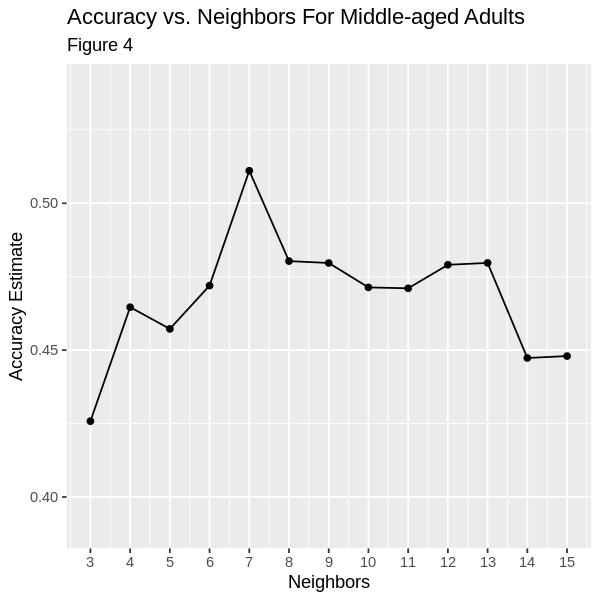

In [15]:
options(repr.plot.width=5,repr.plot.height=5)

#Create a plot of accuracy versus the number of neighbors
accuracy_versus_k_3 <- ggplot(cl_fit_3, aes(x = neighbors, y = mean))+
geom_point() + #Add points to plot
geom_line() + #Connect points with a line
labs(x = "Neighbors", y = "Accuracy Estimate",
    title="Accuracy vs. Neighbors For Middle-aged Adults",
    subtitle="Figure 4") + #Label axis
scale_x_continuous(breaks = seq(3, 15, by = 1)) +  # adjusting the x-axis
scale_y_continuous(limits = c(0.39, 0.54)) # adjusting the y-axis
accuracy_versus_k_3

In [16]:
#Filter Seniors from the dataset
cl_train_4<-cl_train|>
filter(age_group=="Seniors")

#Define a recipe for preprocessing the data
cl_recipe_4<-recipe(num~sex+cp+trestbps+thal,data=cl_train_4)|>
step_center(all_predictors())|> #Center all predictors
step_scale(all_predictors()) #Scale all predictors

#perform 5-fold cross-validation
cl_vfold_4<-vfold_cv(cl_train_4,v=5,strata=num)

#Build the workflow
cl_fit_4<-workflow()|>
add_recipe(cl_recipe_4)|>
add_model(knn_spec)|>
tune_grid(resamples = cl_vfold_4, grid = kgrid)|>
collect_metrics()|>
filter(.metric=="accuracy")

→ A | warning: No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

→ B | warning: No observations were detected in `truth` for level(s): '1', '2', '3', '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1





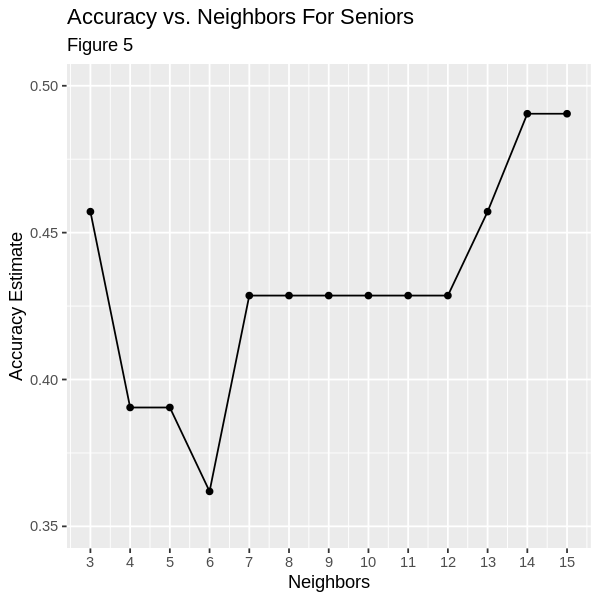

In [17]:
options(repr.plot.width=5,repr.plot.height=5)

#Create a plot of accuracy versus the number of neighbors
accuracy_versus_k_4 <- ggplot(cl_fit_4, aes(x = neighbors, y = mean))+
geom_point() + #Add points to plot
geom_line() + #Connect points with a line
labs(x = "Neighbors", y = "Accuracy Estimate",
    title="Accuracy vs. Neighbors For Seniors",
    subtitle="Figure 5") + #Label axis
scale_x_continuous(breaks = seq(3, 15, by = 1)) +  # adjusting the x-axis
scale_y_continuous(limits = c(0.35, 0.50)) # adjusting the y-axis
accuracy_versus_k_4

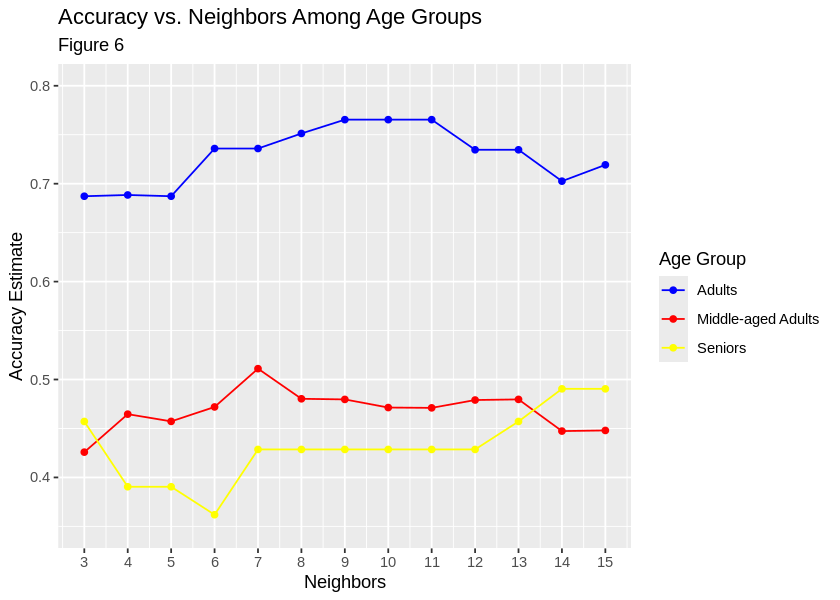

In [18]:
options(repr.plot.width=7,repr.plot.height=5)
# Define the plot with corrected color mappings and scale definitions
together_plot <- ggplot() +
geom_line(data = cl_fit_2, aes(x = neighbors, y = mean, color = "2")) +
geom_point(data = cl_fit_2, aes(x = neighbors, y = mean, color = "2")) +
geom_line(data = cl_fit_3, aes(x = neighbors, y = mean, color = "3")) +
geom_point(data = cl_fit_3, aes(x = neighbors, y = mean, color = "3")) +
geom_line(data = cl_fit_4, aes(x = neighbors, y = mean, color = "4")) +
geom_point(data = cl_fit_4, aes(x = neighbors, y = mean, color = "4")) +
scale_y_continuous(limits = c(0.35, 0.8)) +
labs(x = "Neighbors", y = "Accuracy Estimate", 
    title = "Accuracy vs. Neighbors Among Age Groups",
    subtitle="Figure 6") +
scale_color_manual(values = c("2" = "blue", "3" = "red", "4" = "yellow"),
                     labels = c("Adults", "Middle-aged Adults", "Seniors"),
                     name = "Age Group")+
scale_x_continuous(breaks = seq(3, 15, by = 1))

# Display the plot
together_plot

**Age Groups Performance Summary**
- Adults: This group shows the highest accuracy across all neighbor values, consistently achieving estimates above 0.7, peaking around 0.75. The performance remains relatively stable despite variations in the number of neighbors. 
- Middle-aged Adults and Seniors: Neither of these groups achieve the high accuracy levels observed in the Adult group, with their performances rarely exceeding an accuracy mark of 0.5.
- This suggest that demographic-specific tuning might lead to some performance gains. 

In [19]:
#Find the top performance neighbor in Adults group
top_k<-cl_fit_2|>

#Arrange the performance from top to bottom
arrange(-mean)|>

#Select the top performance neighbor
slice_head()

print("Table 4 Neighbors With Best Performance(Adults)")
top_k

[1] "Table 4 Neighbors With Best Performance(Adults)"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,multiclass,0.7653846,5,0.04880222,Preprocessor1_Model07


In [20]:
#Filter the testing data with only Adults
cl_test_2<-cl_test|>
filter(age_group=="Adults")

#Define a KNN model specification
knn_spec<-nearest_neighbor(weight_func="rectangular",neighbors=9)|>
set_engine("kknn")|>
set_mode("classification")

#Build the workflow
cl_fit_9<-workflow()|>
add_recipe(cl_recipe)|>
add_model(knn_spec)|>
fit(cl_train_2)

#Predict the outcome using trained model on the testing dataset
predict_9<-predict(cl_fit_9,cl_test_2)|>

#Bind the columns of the original testing datasets to the predictions 
bind_cols(cl_test_2)
print("Table 5 Display Predicted Class With Testing Dataset")
predict_9

#Calculate performance metrics for the predictions
accuracy_9<-predict_9|>
metrics(truth = num, estimate = .pred_class)
print("Table 6 Accuracy Table")
accuracy_9

[1] "Table 5 Display Predicted Class With Testing Dataset"


.pred_class,age_group,sex,cp,trestbps,thal,num
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,Adults,1,3,130,3,0
0,Adults,1,4,150,3,0
0,Adults,1,4,140,3,0
1,Adults,1,4,120,7,3
0,Adults,1,4,104,3,0
0,Adults,1,3,140,3,0
0,Adults,0,4,138,3,0
0,Adults,1,2,128,3,0
3,Adults,1,4,126,7,1


[1] "Table 6 Accuracy Table"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5500000
kap,multiclass,0.1666667


The tibbles above indicates that while the model effectively predicts the presence of heart disease, it struggles with accurately determining the number of narrowed vessels[2]. Consequently, we will simplify the target variables "num" and ".pred_class", transforming them from multiclass variables into binary format. In this new level, 
 - "0" will represent the absence of heart disease
 - "1" will represent the presence of heart disease

In [21]:
#Recode "num" and ".pred_class"
new_predict_9 <- predict_9 |>

#Recode predicted class, consolidate classes "2", "3" and "4" into "1"
mutate(.pred_class = fct_recode(.pred_class, "1" = "2", "1" = "3", "1" = "4")) |>

#Recode actual outcome "num", consolidate classes "2", "3" and "4" into "1"
mutate(num = fct_recode(num, "1" = "2", "1" = "3", "1" = "4"))

#Calculate the accuracy matrics for the recoded prediction and actual outcome data
new_accuracy_9<-new_predict_9|>
metrics(truth = num, estimate = .pred_class)

print("Table 7 Updated Accuracy")
new_accuracy_9

[1] "Table 7 Updated Accuracy"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8000000
kap,binary,0.5652174


---
## Discussion:
 **Summary**
 - Adults group shows the highest accuracy across all neighbor values, consistently achieving estimates above 0.7, peaking around 0.75. The performance remains relatively stable despite variations in the number of neighbors. Neither of Middle-aged Adults nor Seniors achieve the high accuracy levels observed in the Adult group, with their performances rarely exceeding an accuracy mark of 0.5. This suggest that demographic-specific tuning might lead to some performance gains. After transforming the target variables "num and ".pred_class" from multiclass to binary format, the predicted accuracy incraesed significanlty. This simplification suggests that a binary classification appraoch is more effective and could be better suited for practical application, especially in distinguishing the presence versus absence of heart disease more clearly.

**Expectation**
 - At the beginning of the project, I was expected to find a significant relationship between the selected predictor variables and the severity of heart disease across different age groups. By the conclusion of the study, I had established that these predictor variables indeed show a significant correlation with the presence of heart disease, particularly among adults.

**Impact**
 - Discovering a significant relationship between selected predictor variables and the presence of heart disease, especially among adults, can be intergrated into clinical decision support system to aid healthcare providers in diagnosing heart disease more accurately and promptly. This can lead to earlier interventions, which are often crucial for improving patient outcomes.

**Future Questions**
 - "Is the sample representative?" To determine whether the study's findings can be applied to a broader population, the sample has to be representative of the general population.
 - "What is the cost-effectiveness of implementing screening programs based on these predictors?" A cost-benefit analysis needs to be performed before implementation.

---
## References

- [1]Ali MM;Paul BK;Ahmed K;Bui FM;Quinn JMW;Moni MA; “Heart Disease Prediction Using Supervised Machine Learning Algorithms: Performance Analysis and Comparison.” Computers in Biology and Medicine, U.S. National Library of Medicine, pubmed.ncbi.nlm.nih.gov/34315030/. Accessed 21 June 2024. 
- [2]Luo Y;Xiao Y;Liu J;Wu Y;Zhao Z; “Design and Application of a Flexible Nano Cardiac Sound Sensor Based on P(VDF-TrFE)/KNN/GR Composite Piezoelectric Film for Heart Disease Diagnosis.” Nanotechnology, U.S. National Library of Medicine, pubmed.ncbi.nlm.nih.gov/37857282/. Accessed 21 June 2024. 

---